In [1]:
import pandas as pd
import pandas.plotting as pp
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
import numpy as np
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split, KFold
from sklearn.feature_selection import VarianceThreshold
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import shuffle



import seaborn as sns
from sklearn import tree
from sklearn import ensemble
from sklearn import metrics
from sklearn import model_selection
from sklearn.model_selection import GridSearchCV
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import KFold
pd.set_option('display.max_rows', 100)
import warnings
warnings.filterwarnings("ignore")

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Import Final Dataset

In [3]:
# Import final dataset from preprocessing 2

data= pd.read_csv('/content/drive/MyDrive/RAKAMIN (Bootcamp & JAP)/home-credit-default-risk/Final_dataset.csv')
data.head()

,AMT_CREDIT_SUM,DAYS_CREDIT_UPDATE,DAYS_CREDIT,CREDIT_ACTIVE_Active,CREDIT_ACTIVE_Closed,CREDIT_TYPE_Microloan,buro_count,AMT_DOWN_PAYMENT,RATE_DOWN_PAYMENT,CNT_INSTALMENT,...,DAYS_BIRTH,REGION_POPULATION_RELATIVE,AMT_CREDIT_x,AMT_INCOME_TOTAL,REG_CITY_NOT_WORK_CITY,HOUSETYPE_MODE_block of flats,EMERGENCYSTATE_MODE_No,ORGANIZATION_TYPE_XNA,OCCUPATION_TYPE_Laborers,TARGET
0,6.955005e+05,-1530.333333,-1826.333333,0.000,1.000,0.0,3.0,3.78,0.000030,19.471698,...,-12170.0,0.009657,869296.5,202500.0,0.0,1.0,1.0,0.0,0.0,0.0
1,3.836853e+05,-209.000000,-1004.800000,1.000,0.000,0.0,5.0,8685.00,0.099458,11.947368,...,-10885.0,0.008068,207306.0,112500.0,0.0,0.0,0.0,0.0,0.0,1.0
2,2.902989e+05,-730.000000,-1433.125000,0.375,0.625,0.0,8.0,13918.50,0.518958,12.000000,...,-18711.0,0.006305,942300.0,112500.0,1.0,0.0,0.0,0.0,0.0,0.0
3,2.250000e+05,-7.000000,-441.000000,0.000,1.000,0.0,1.0,0.00,0.000000,18.000000,...,-20503.0,0.026392,675000.0,103500.0,0.0,0.0,0.0,1.0,0.0,0.0
4,1.800000e+06,-760.000000,-1186.000000,0.000,1.000,0.0,1.0,10165.50,0.156673,11.090909,...,-16973.0,0.020713,761872.5,189000.0,0.0,0.0,1.0,0.0,1.0,1.0


## Data Seperation

In [4]:
#Extracting Y value from the dataframe

filtered_columns = [i for i in data.columns if i not in ['TARGET']]
y = data.TARGET
x = data[filtered_columns]

In [5]:
# Split into train & test with 30% test size

x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.3, random_state=7)

In [6]:
# Check the split shapes

print('X_train:', x_train.shape)
print('Y_train:', y_train.shape)
print('X_test:', x_test.shape)
print('Y_test:', y_test.shape)

X_train: (395760, 93)
Y_train: (395760,)
X_test: (169612, 93)
Y_test: (169612,)


## Scale the test & train datasets

In [7]:
# Scaling the test and train dataframes

num_cols = x_test.columns
scaler_num = StandardScaler()
x_train_num1 = scaler_num.fit_transform(x_train)

x_train_num1 = scaler_num.transform(x_train)
x_test_num1 = scaler_num.transform(x_test)

x_train = pd.DataFrame(x_train_num1, columns=num_cols)
x_test = pd.DataFrame(x_test_num1, columns=num_cols)

# Modeling

##  Logistic Regression

In [11]:
logistic = LogisticRegression(random_state=42, n_jobs=10)
logistic.fit(x_train,y_train)
predictions = logistic.predict_proba(x_test)[:, 1]
auc = metrics.roc_auc_score(y_test, predictions)
print('AUC:',auc) 

AUC: 0.7427813723586734


## Random Forest

In [12]:
forest = ensemble.RandomForestClassifier(random_state=42, n_jobs=10)
forest.fit(x_train,y_train)
predicted_y = forest.predict(x_test)
auc = metrics.roc_auc_score(y_test, predicted_y)
print('AUC:',auc)

AUC: 0.9979289365389986


## Building a VotingClassifier

### Kfold validation

In [13]:
data= x_train
y = y_train
folds = KFold(n_splits=5, shuffle=True, random_state=7777777)
oof_preds = np.zeros(data.shape[0])


feature_importance_df = pd.DataFrame()

feats = [f for f in data.columns if f not in ['SK_ID_CURR']]

for n_fold, (trn_idx, val_idx) in enumerate(folds.split(data)):
    trn_x, trn_y = data[feats].iloc[trn_idx], y.iloc[trn_idx]
    val_x, val_y = data[feats].iloc[val_idx], y.iloc[val_idx]
    voting =ensemble.VotingClassifier(estimators=[('forest', forest),
                                              ('logit', logistic)], voting='soft', n_jobs=10, flatten_transform=True)
    voting.fit(trn_x, trn_y
           )
    oof_preds[val_idx] = voting.predict(val_x)
    print('Fold %2d AUC : %.6f' % (n_fold + 1, metrics.roc_auc_score(val_y, oof_preds[val_idx])))
    del voting, trn_x, trn_y, val_x, val_y

print('Full AUC score %.6f' % metrics.roc_auc_score(y, oof_preds)) 

Fold  1 AUC : 0.954413
Fold  2 AUC : 0.954116
Fold  3 AUC : 0.953055
Fold  4 AUC : 0.953546
Fold  5 AUC : 0.955154
Full AUC score 0.954057


### Training the model

In [14]:
# Train the voting classifier
voting =ensemble.VotingClassifier(estimators=[('forest', forest),
                                              ('logit', logistic)], voting='soft',n_jobs=10, flatten_transform=True)
voting.fit(x_train,y_train)

VotingClassifier(estimators=[('forest',
                              RandomForestClassifier(n_jobs=10,
                                                     random_state=42)),
                             ('logit',
                              LogisticRegression(n_jobs=10, random_state=42))],
                 n_jobs=10, voting='soft')

In [15]:
predicted_y = voting.predict(x_test)

### Classification Report

In [16]:
auc = metrics.roc_auc_score(y_test, predicted_y)
accuracy = metrics.accuracy_score(y_test, predicted_y)
print(classification_report(y_test, predicted_y))
print('AUC:',auc)
print('Accuracy:',accuracy)

              precision    recall  f1-score   support

         0.0       1.00      0.93      0.96     84729
         1.0       0.93      1.00      0.97     84883

    accuracy                           0.96    169612
   macro avg       0.97      0.96      0.96    169612
weighted avg       0.97      0.96      0.96    169612

AUC: 0.9642394724790875
Accuracy: 0.9642713958918001


###  Confusion Matrix

Text(0.5, 257.44, 'Predicted label')

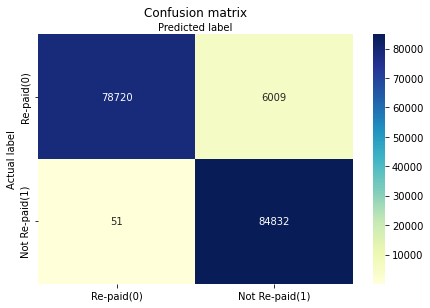

In [17]:
cnf_matrix = metrics.confusion_matrix(y_test, predicted_y)
class_names=['Re-paid(0)','Not Re-paid(1)'] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g', xticklabels=class_names,
    yticklabels=class_names)
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

### ROC Curve

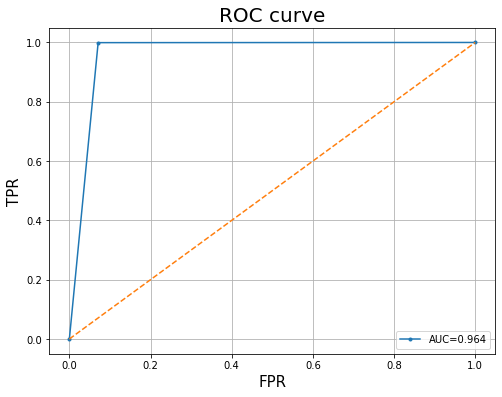

In [18]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, predicted_y)
auc = metrics.roc_auc_score(y_test, predicted_y)
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, marker='.')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.title('ROC curve', fontsize = 20)
plt.xlabel('FPR', fontsize=15)
plt.ylabel('TPR', fontsize=15)
plt.grid()
plt.legend(["AUC=%.3f"%auc])
plt.show()

## Top 20 feature Importances

In [19]:
features = dict(zip(x_train.columns, forest.feature_importances_))
df=pd.DataFrame(features.items(), columns=['Features','Values'])

df = df.sort_values('Values', ascending=False).reset_index(drop=True)
df.index = df.index + 1
df = df.reset_index().rename(columns={'index': 'Rank'}).set_index('Rank')
df.head(20)

,Features,Values
Rank,,
1,EXT_SOURCE_2,0.062550
2,DAYS_CREDIT,0.027564
3,DAYS_BIRTH,0.026960
4,DAYS_EMPLOYED,0.022319
5,DAYS_CREDIT_UPDATE,0.021538
6,DAYS_ID_PUBLISH,0.020667
7,AMT_ANNUITY_x,0.020306
8,AMT_PAYMENT,0.020215
9,DAYS_REGISTRATION,0.019838
